In [2]:
# === Cell 1: Imports & functions ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# I0 ↔ E 的互相转换（与你原脚本一致）
# -----------------------------
def I0_from_E(E, w, tau):
    """I0 = (4 sqrt(ln2) / pi^(3/2)) * E / (w^2 * tau)"""
    return (4.0 * np.sqrt(np.log(2.0)) / (np.pi ** 1.5)) * E / (w**2 * tau)

def E_from_I0(I0, w, tau):
    """E = I0 * (pi^(3/2) / (4 sqrt(ln2))) * w^2 * tau"""
    return I0 * ((np.pi ** 1.5) / (4.0 * np.sqrt(np.log(2.0)))) * (w**2) * tau

# -----------------------------
# 读取薄膜剖面：支持传入 DataFrame 或 CSV 文件
# -----------------------------
def _select_cols(df, r_candidates, t_candidates):
    r_col = next((c for c in r_candidates if c in df.columns), None)
    t_col = next((c for c in t_candidates if c in df.columns), None)
    return r_col, t_col

def read_film_profile_from_df(df: pd.DataFrame):
    """
    从给定 DataFrame 读取 (r_m, t_m)，返回 (r_m, t_m, used_file, used_cols)
    used_file 用 '<in-memory DataFrame>' 表示，used_cols 给出实际使用的列名。
    """
    r_candidates = ["r_mm", "r_in_mm", "radius_mm"]
    t_candidates = ["film_after_mm", "t_flat_mm", "film_mm", "t_mm", "film_before_mm"]
    r_col, t_col = _select_cols(df, r_candidates, t_candidates)
    if r_col is None or t_col is None:
        raise ValueError(f"DataFrame 缺少必要列。可用列：{list(df.columns)}")
    r_mm = df[r_col].to_numpy(dtype=float)
    t_mm = df[t_col].to_numpy(dtype=float)
    return 1e-3*r_mm, 1e-3*t_mm, "<in-memory DataFrame>", (r_col, t_col)

def read_film_profile_from_csv(film_csv: str):
    """
    从 CSV 读取 (r_m, t_m)，优先 step11_profiles_film_mirror_radial.csv，
    若列缺失则回退 step11_layers_film_mirror_abs.csv。
    返回 (r_m, t_m, used_file, used_cols)。
    """
    tried = []
    # 1) 首选：传入路径
    if os.path.exists(film_csv):
        df = pd.read_csv(film_csv)
        r_candidates = ["r_mm", "r_in_mm", "radius_mm"]
        t_candidates = ["film_after_mm", "t_flat_mm", "film_mm", "t_mm", "film_before_mm"]
        r_col, t_col = _select_cols(df, r_candidates, t_candidates)
        if r_col is not None and t_col is not None:
            r_mm = df[r_col].to_numpy(dtype=float)
            t_mm = df[t_col].to_numpy(dtype=float)
            return 1e-3*r_mm, 1e-3*t_mm, film_csv, (r_col, t_col)
        tried.append((film_csv, list(df.columns)))

    # 2) 回退：per-layer 表
    fallback = "step11_layers_film_mirror_abs.csv"
    if os.path.exists(fallback):
        df = pd.read_csv(fallback)
        # 常见的两列：r_in_mm, film_after_mm
        if ("r_in_mm" in df.columns) and ("film_after_mm" in df.columns):
            r_mm = df["r_in_mm"].to_numpy(dtype=float)
            t_mm = df["film_after_mm"].to_numpy(dtype=float)
            return 1e-3*r_mm, 1e-3*t_mm, fallback, ("r_in_mm", "film_after_mm")
        tried.append((fallback, list(df.columns)))

    # 若均失败，抛详细错误
    msg = ["无法在以下文件中找到所需列："]
    for fname, cols in tried:
        msg.append(f"- {fname}（可用列：{cols}）")
    if not tried:
        msg.append(f"- 未找到 {film_csv} 或 {fallback}")
    raise FileNotFoundError("\n".join(msg))

# -----------------------------
# 主函数：在不改薄膜的前提下，调能量使 r=0 处 B 命中目标
# -----------------------------
def calibrate_energy_for_target_B(
    B_target: float,
    film_csv: str = "step11_profiles_film_mirror_radial.csv",
    film_df: pd.DataFrame | None = None,
    lambda_nm: float = 800.0,
    n2: float = 2.24e-20,
    w_mm: float = 4.0,
    tau_fs: float = 40.0,
    save: bool = True,
    out_prefix: str = "B_profile_new_energy",
    dpi: int = 180,
    show: bool = True,
):
    """
    基于既有薄膜剖面（固定），通过调整能量使 r=0 处 B = B_target，并给出 B(r) 分布。

    参数
    ----
    B_target : float
        目标 B 积分（在 r=0 处命中）。
    film_csv : str
        CSV 路径，默认 "step11_profiles_film_mirror_radial.csv"。
    film_df : pd.DataFrame | None
        若已在内存中有 DataFrame，可直接提供，优先使用。
    lambda_nm, n2, w_mm, tau_fs : float
        物理参数，默认与你原脚本一致。
    save : bool
        是否写出 PNG/CSV 文件。
    out_prefix : str
        输出文件前缀（当 save=True 时有效）。
    dpi : int
        保存图像 DPI。
    show : bool
        是否在 Jupyter 中显示图像。

    返回
    ----
    result : dict
        {
          'E_new_J', 'E_new_mJ', 'I0_new', 'B_target',
          'used_file', 'used_cols',
          'df': DataFrame(r_mm, t_mm, B_r),
          'fig': matplotlib.figure.Figure
        }
    """
    # 单位换算
    lam = lambda_nm * 1e-9   # m
    w   = w_mm * 1e-3        # m
    tau = tau_fs * 1e-15     # s

    if film_df is not None:
        r_m, t_m, used_file, used_cols = read_film_profile_from_df(film_df)
    else:
        r_m, t_m, used_file, used_cols = read_film_profile_from_csv(film_csv)

    # 排序去重 + 若无 r=0 则前置一个阶梯点
    order = np.argsort(r_m)
    r_m = r_m[order]
    t_m = t_m[order]

    # 去重（有些 CSV 可能有重复半径）
    uniq, idx = np.unique(r_m, return_index=True)
    r_m = r_m[idx]
    t_m = t_m[idx]

    if r_m[0] > 1e-15:
        r_m = np.concatenate([[0.0], r_m])
        t_m = np.concatenate([[t_m[0]], t_m])

    # 常量
    B_const = (2.0 * np.pi / lam) * n2  # (1/W·m)

    # 反解能量：让 r=0 的 B 命中
    t0 = t_m[0]
    if t0 <= 0:
        raise ValueError(f"r=0 处薄膜厚度 t0={t0:g} 不合理（应>0）。文件/数据：{used_file}")

    I0_new = B_target / (B_const * t0)
    E_new  = E_from_I0(I0_new, w, tau)

    # 计算 B(r)
    I_r = I0_new * np.exp(-2.0 * (r_m**2) / (w**2))
    B_r = B_const * I_r * t_m
    hit_err = float(B_r[0] - B_target)

    # 组织结果表
    df_out = pd.DataFrame({
        "r_mm": r_m * 1e3,
        "t_mm": t_m * 1e3,
        "B_r":  B_r
    })

    # 绘图（单一图，不指定颜色）
    fig = plt.figure(figsize=(7.0, 4.2))
    plt.plot(df_out["r_mm"], df_out["B_r"], label="B(r) at t=0")
    plt.axvline(w_mm, linestyle="--", label="r = w")
    plt.axhline(B_target, linestyle=":", label=f"B_target = {B_target:g}")
    plt.xlabel("r (mm)")
    plt.ylabel("B(r)")
    plt.title("B-integral along radius with re-scaled energy (film fixed)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if show:
        plt.show()

    # 保存
    if save:
        csv_path = f"{out_prefix}.csv"
        png_path = f"{out_prefix}.png"
        df_out.to_csv(csv_path, index=False)
        fig.savefig(png_path, dpi=dpi)

    # 控制台输出（在 Jupyter 里也会显示）
    print("=== 计算结果（基于既有薄膜，能量重标）===")
    print(f"使用的薄膜：{used_file}（列：{used_cols}）")
    print(f"物理参数：λ = {lambda_nm:.3f} nm, n2 = {n2:.3e} m^2/W, w = {w_mm:.3f} mm, τ = {tau_fs:.3f} fs")
    print(f"目标 B（r=0）：{B_target:.6f}")
    print(f"所需新能量 E_new：{E_new:.6f} J  ({E_new*1e3:.3f} mJ)")
    print(f"峰值强度 I0_new：{I0_new:.6e} W/m^2")
    print(f"B(0) 命中误差：{hit_err:+.3e}  （数值波动应≈0）")

    return {
        "E_new_J": E_new,
        "E_new_mJ": E_new*1e3,
        "I0_new": I0_new,
        "B_target": B_target,
        "used_file": used_file,
        "used_cols": used_cols,
        "df": df_out,
        "fig": fig,
    }


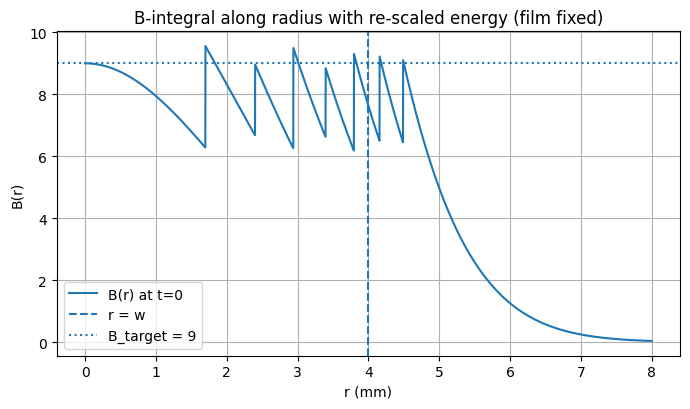

=== 计算结果（基于既有薄膜，能量重标）===
使用的薄膜：step11_profiles_film_mirror_radial.csv（列：('r_mm', 'film_after_mm')）
物理参数：λ = 800.000 nm, n2 = 2.240e-20 m^2/W, w = 4.000 mm, τ = 40.000 fs
目标 B（r=0）：9.000000
所需新能量 E_new：0.540000 J  (540.000 mJ)
峰值强度 I0_new：5.046168e+17 W/m^2
B(0) 命中误差：+0.000e+00  （数值波动应≈0）


,r_mm,t_mm,B_r
0,0.000,0.101378,9.000000
1,0.002,0.101378,8.999996
2,0.004,0.101378,8.999982
3,0.006,0.101378,8.999960
4,0.008,0.101378,8.999928


In [9]:
# === Cell 2: Set parameters & run ===

# 你想命中的目标 B（r=0）
B_target = 9.0

# 如果你的最终薄膜数据在默认文件（推荐）：
film_csv_path = "step11_profiles_film_mirror_radial.csv"

# 若你已经把薄膜表读成了 DataFrame（任选其一方式）：
# film_df = pd.read_csv("step11_profiles_film_mirror_radial.csv")
film_df = None  # 这里先设为 None，即用 CSV 读取

result = calibrate_energy_for_target_B(
    B_target=B_target,
    film_csv=film_csv_path,
    film_df=film_df,           # 若传 DataFrame，则优先使用该 DF
    lambda_nm=800.0,
    n2=2.24e-20,
    w_mm=4.0,
    tau_fs=40.0,
    save=True,                 # 需要写出 PNG/CSV 就设 True
    out_prefix="B_profile_new_energy",
    dpi=180,
    show=True,                 # 在 notebook 里显示图
)

# 可直接查看结果 DataFrame 的前几行
result["df"].head()
